# Source notebook for generating videos

In [1]:
# default_exp utils_videos

In [2]:
# hide
import sys
sys.path.insert(0, "..")
import nbdev
from nbdev.showdoc import *

In [3]:
# export
import numpy as np
import matplotlib.pyplot as plt

import deeptrack as dt

/opt/anaconda3/envs/handi/lib/python3.8/site-packages/deeptrack/backend/_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
/opt/anaconda3/envs/handi/lib/python3.8/site-packages/deeptrack/backend/_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")


## 1. Generate test trajectories

### 1.1. Multi state diffusion

In [4]:
# hide
from andi_datasets.models_phenom import models_phenom

In [5]:
T = 500 # number of time steps (frames)
N = 50 # number of particles (trajectories)
L = 1.5 * 128 # length of the box (pixels) -> exteneding fov by 1.5 times
D = 0.1 # diffusion coefficient (pixels^2/frame)

In [6]:
trajs_model2, labels_model2 = models_phenom().multi_state(
    N=N,
    L=L,
    T=T,
    alphas=[1.2, 0.7],
    Ds=[10 * D, 0.1 * D],
    M=np.array([[0.98, 0.02], [0.02, 0.98]]),
)

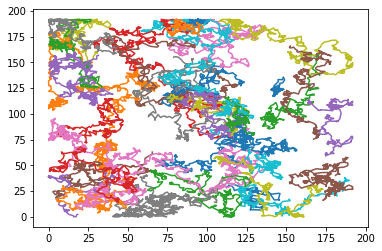

In [7]:
reshaped_trajs = np.moveaxis(trajs_model2, 0, 1)
for traj in reshaped_trajs:
    plt.plot(traj[:,0], traj[:,1])
plt.show()

## 2. Function to generate videos

In [8]:
# export
def get_video_andi(
    trajectory_data, scatter_kwargs={}, optics_kwargs={}, noise_kwargs={}
):
    """
    Generates a video from the trajectories generated by create_dataset(). Uses process_data_from_andi() to adjust the initial positions of the trajectories.
    Arguments:
        trajectory_data: AnDi dataset generated from create_dataset()
        scatter_kwargs (dict): Can be used to change the particle properties (intensity, z, position)
        optics_kwargs (dict): Can be used to change the optics properties (NA, wavelength, resolution, magnification, output_region)
        noise_kwargs (dict): Can be used to modify the snr of the video

    Users need to do get_video_andi(trajectory_data).update().resolve() to generate the video, and get_video_andi(trajectory_data).update().plot() to visualize the video

    """

    _particle_dict = {
        "intensity": lambda: 1
        + np.random.rand() * 9,  # particle intensities can be modified
        "z": lambda: np.random.rand() * 5,
        "refractive_index": lambda: 1.4 + np.random.rand() * 0.2,
        "position_unit": "pixel",
    }

    _optics_dict = {
        "NA": lambda: 0.6 + np.random.rand() * 0.2,  # 1,
        "wavelength": 500e-9,
        "resolution": 1e-6,  # 5e-6
        "magnification": 10,  # effective pixel size is 100 nm # magnifiction changed to 10
        "upscale": 4,
        "refractive_index_medium": 1.33,
        "output_region": [0, 0, 128, 128],
    }

    _noise_dict = {
        "snr": lambda: 4 + np.random.rand() * 3,
    }

    # Update the dictionaries with the user-defined values
    _particle_dict.update(scatter_kwargs)
    _optics_dict.update(optics_kwargs)
    _noise_dict.update(noise_kwargs)

    # Reshapa the trajectory
    trajectory_data = np.moveaxis(trajectory_data, 0, 1)

    # Generate point particles
    particle = dt.PointParticle(
        trajectories=trajectory_data,
        replicate_index=lambda _ID: _ID,
        trajectory=lambda replicate_index, trajectories: dt.units.pixel
        * trajectories[replicate_index[-1]],
        traj_pointer=lambda replicate_index: replicate_index[-1],
        number_of_particles=trajectory_data.shape[0],
        traj_length=trajectory_data.shape[1],
        position=lambda trajectory: trajectory[0],
        **_particle_dict,
    )

    # Make it sequential
    sequential_particle = dt.Sequential(
        particle,
        position=lambda trajectory, sequence_step: trajectory[sequence_step],
    )

    # Define optical setup
    optics = dt.Fluorescence(**_optics_dict)

    # Normalise the intensity
    normalization = dt.NormalizeMinMax(
        min=lambda: np.random.rand() * 0.4,
        max=lambda min: min + 0.1 + np.random.rand() * 0.5,
    )

    # Add shot noise
    noise = dt.Poisson(
        **_noise_dict,
        background=normalization.min,
    )

    # sample
    sample = optics(particle ^ particle.number_of_particles) >> normalization >> noise

    # Sequential sample
    sequential_sample = dt.Sequence(
        sample,
        trajectory=particle.trajectories,
        sequence_length=particle.traj_length,
    )

    return sequential_sample

## Testing the function

In [10]:
origin = 0 # pixels
video = get_video_andi(trajs_model2, optics_kwargs={"output_region": [origin, origin, 200, 200]})

In [11]:
video_frames = video.update().resolve()

/opt/anaconda3/envs/handi/lib/python3.8/site-packages/deeptrack/optics.py:221: RuntimeWarning: invalid value encountered in sqrt
  * np.sqrt(1 - (NA / refractive_index_medium) ** 2 * RHO),


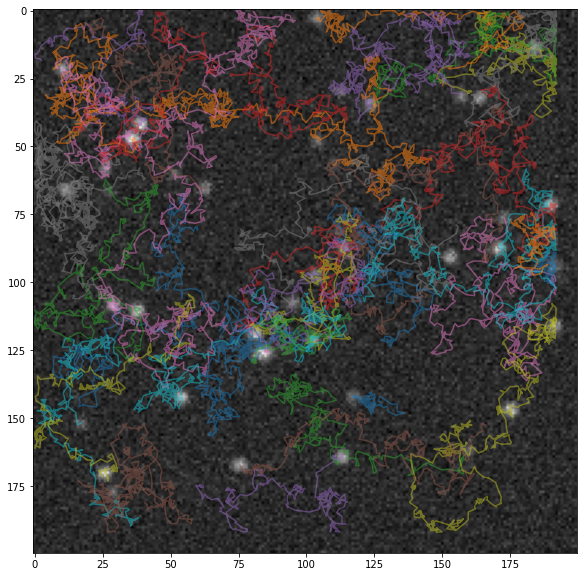

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(video_frames[0], cmap="gray")
for traj in np.moveaxis(trajs_model2, 0, 1):
    plt.plot(traj[:,1][:1000], traj[:,0][:1000], alpha=0.5)
plt.show()

Save the notebook before running the below cell. It will erase all the source files otherwise

In [14]:
from nbdev.export import notebook2script
notebook2script()

Converted analysis.ipynb.
Converted creating_videos_phenom.ipynb.
Converted datasets_phenom.ipynb.
Converted datasets_theory.ipynb.
Converted models_phenom.ipynb.
Converted models_theory.ipynb.
Converted utils_challenge.ipynb.
Converted utils_trajectories.ipynb.
Converted utils_videos.ipynb.
